<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси на следующий час

Заказчиком является кампания, предоставляющася услуги такси. 

Трубуется подготовить прототип модели машинного обучения, которая должна предсказать количество заказов такси в аэропорту на следующий час. Модель поможет оптимизировать количество водителей, привлекаемых к работе в аропорте.

**Данные**: файл `taxi.csv`. Столбцы: 
- `num_orders` - количество заказов
- `datetime` - дата, время

## План работы

 - Загрузка библиотек
 - Загрузка данных
     - ресемплирование данных по 1 часу.
 - Исследование данных (тренд, сезонность)
 - Провести обучение нескольких моделей и выбрать лучшую
 - Сравнить предсказание на тестовых данных и сами тестовые данные
Для оценки качества моделей будет использоваться метрика RMSE

## Подготовка

In [1]:
#установка недостающих библиотек  и недостающих обновлений в окружение
!pip install -U scikit-learn -q

In [2]:
#импорт библиотек и определение констант
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit
)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import tree


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
 
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression )

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import root_mean_squared_error

import warnings

In [3]:
RANDOM_STATE = 42

In [4]:
#загрузка файла 
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод**
Загружены данные из файла taxi.csv. Проведено ресемплирование по дате по одному часу.

 - число строк после ресемплирования: 4 416
 - число столбцов: 1
 - пустые значения: нет
 - типы данных: соответствуют данным в файле
 - переименование столбцов: не требуется

## Анализ

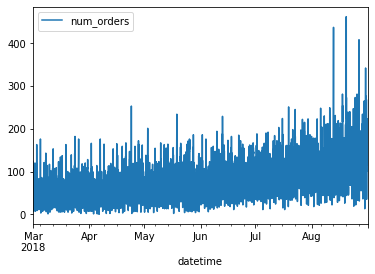

In [5]:
# график num_orders
data.plot();

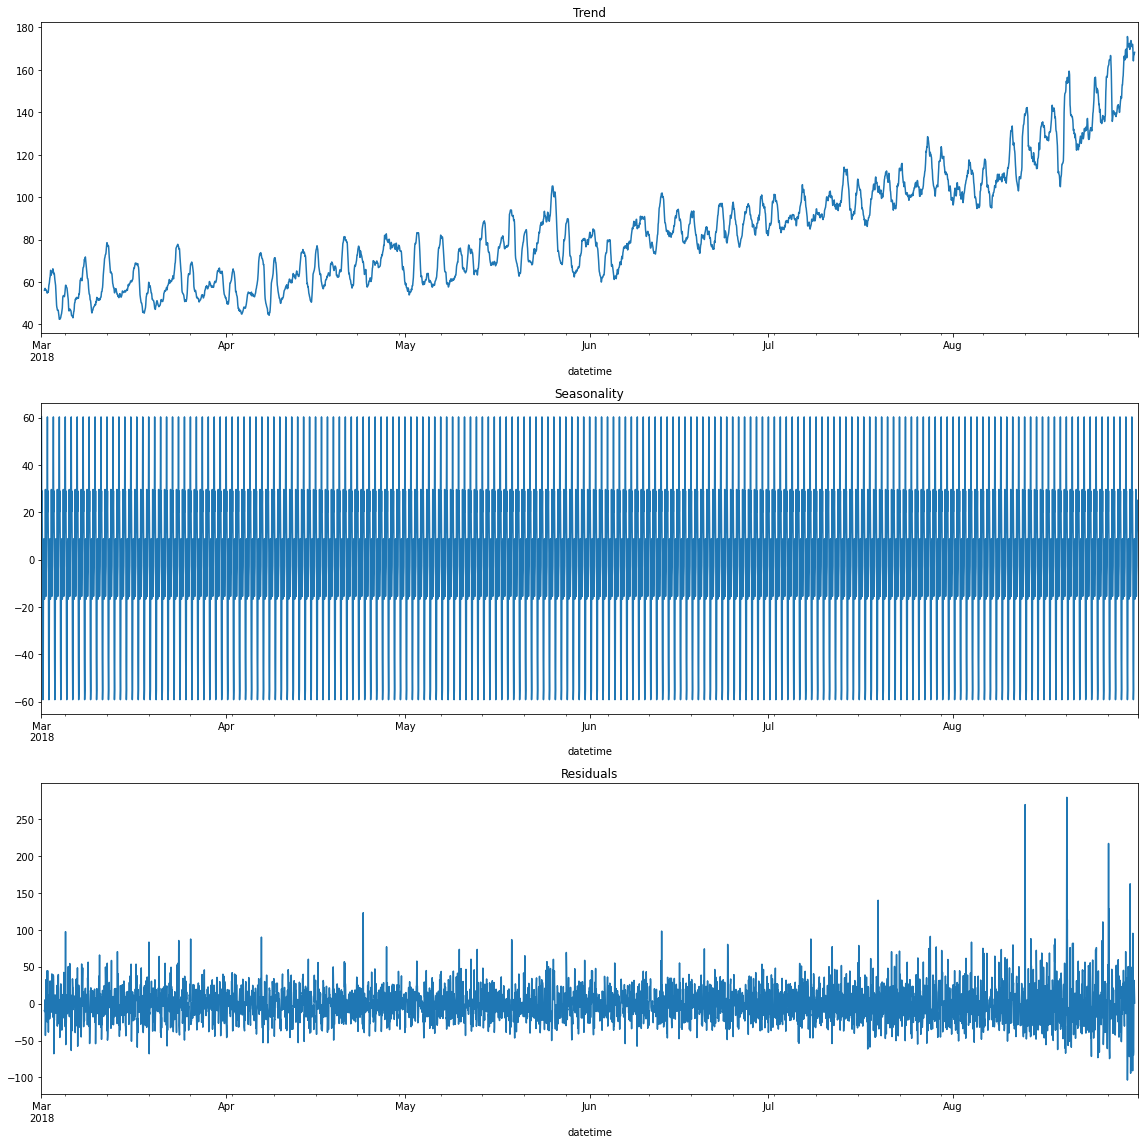

In [6]:
# изучение трендов и сезонности изменения num_orders
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

/tmp/ipykernel_1734/2398370748.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  decomposed = seasonal_decompose(data['2018-04'])


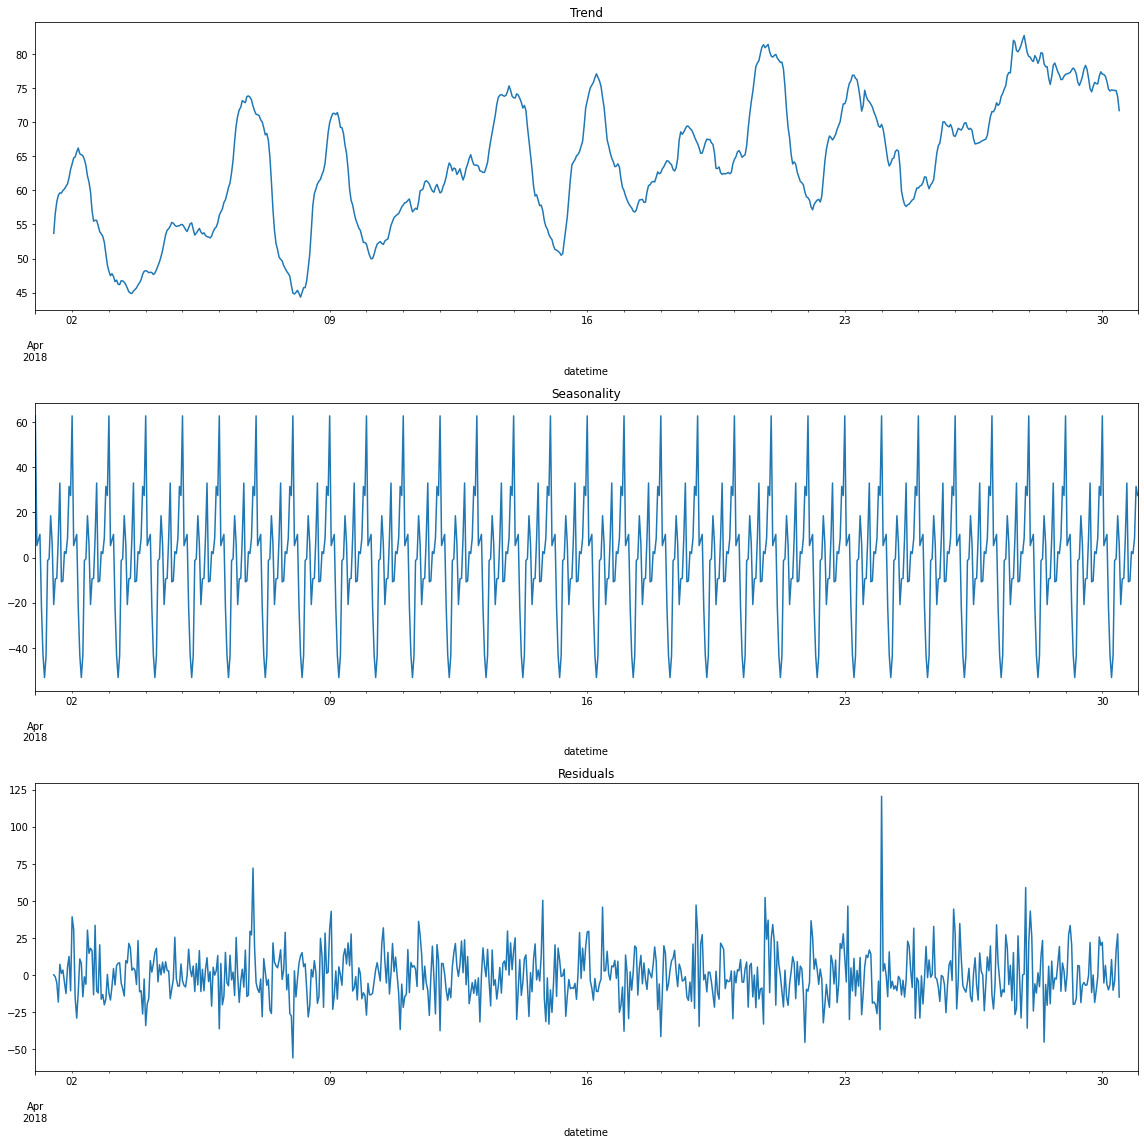

In [7]:
# изучение трендов и сезонности изменения num_orders на более коротком интервале
decomposed = seasonal_decompose(data['2018-04'])

plt.figure(figsize=(16, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [8]:
#добавление признаков для дальнейшего анализа
def new_features(df):
    new_df = df.copy()
    new_df['year'] = new_df.index.year
    new_df['month'] = new_df.index.month
    new_df['week'] = new_df.index.week
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    return new_df
    
def lags(df, max_lag, rolling_mean_size):
    new_df = df.copy()
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_df

data_new_features = new_features(data)
data_ml = lags(data_new_features, 28, 14)

data_ml.head()

/tmp/ipykernel_1734/3875089239.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  new_df['week'] = new_df.index.week


,num_orders,year,month,week,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,9,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,9,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,9,1,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,9,1,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,9,1,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# удаление строк со значениями nan
data_ml = data_ml.dropna()
data_ml.head()

,num_orders,year,month,week,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 04:00:00,20,2018,3,9,2,4,64.0,75.0,120.0,90.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.000000
2018-03-02 05:00:00,11,2018,3,9,2,4,20.0,64.0,75.0,120.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,67.000000
2018-03-02 06:00:00,11,2018,3,9,2,4,11.0,20.0,64.0,75.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,63.071429
2018-03-02 07:00:00,7,2018,3,9,2,4,11.0,11.0,20.0,64.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,60.785714
2018-03-02 08:00:00,46,2018,3,9,2,4,7.0,11.0,11.0,20.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,58.142857


In [10]:
# создание списка
num_columns = list(data_ml.drop('num_orders', axis=1).columns)
num_columns

['year',
 'month',
 'week',
 'day',
 'dayofweek',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'rolling_mean']

In [11]:
def hist_box_diagramm(df, list):
    """
    функция для строительства гистограммы и ящика с усами.
    на вход получает датафрейм и список полей для которых нужно построить графики
    """
    for element in list:   
        
        # создание объекта из двух: гстограммы и ящика с усами
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)})
        
        # назначение графика каждой переменной
        sns.boxplot(df[element], orient='h', ax=ax_box)
        sns.histplot(df, x=element);
        
        print(f"Графики для поля: {element}")

        # удаление подписи для оси х
        ax_box.set(xlabel='')
        plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: num_orders


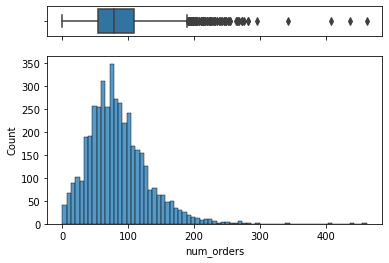

Графики для поля: month


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


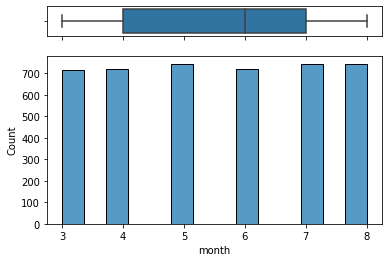

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: week


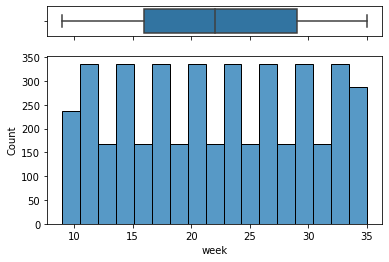

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Графики для поля: day


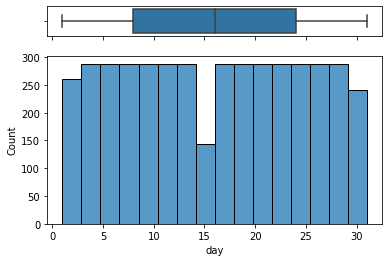

Графики для поля: dayofweek


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


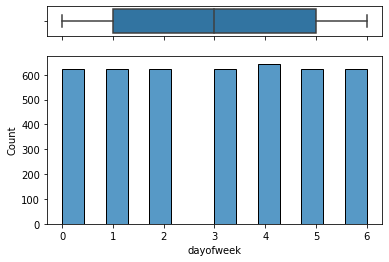

Графики для поля: rolling_mean


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


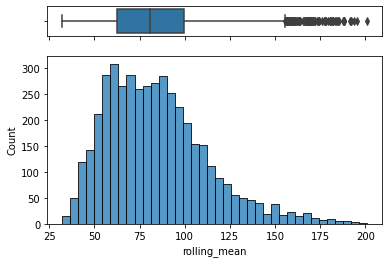

In [12]:
# построение гистограмм для всех признаков
hist_box_diagramm(data_ml, ['num_orders', 'month', 'week', 'day', 'dayofweek', 'rolling_mean'])

Т.к. в поле year присутствует одно единственное значение (2018), то нужно удалить этот столбец из датасета.

In [13]:
#удаление столбца year
data_ml = data_ml.drop('year', axis=1)

In [14]:
def corr_num(df, list):

    """
    функция, которая строит матрицу корреляций Пирсона. На вход получает датафрейм и список числовых параметров
    для которых требуется найти корреляцию. На выходе выдает матрицу корреляции
    """
    
    plt.figure(figsize=(8, 6));
    sns.heatmap(df
                .loc[:, list]  #отбор нужных столбцов
                .corr(), annot=True, cmap='coolwarm', vmin=-1 # построение матрицы корреляции
               );
    plt.title('Корреляционная матрица между числовыми параметрами');
    

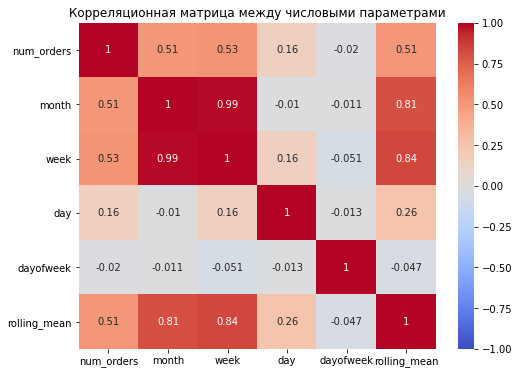

In [15]:
# постороение матрицы корреляции
corr_num(data_ml, ['num_orders', 'month', 'week', 'day', 'dayofweek', 'rolling_mean'])

**Вывод**
Проверка тренда и сезонности:
 - тренд восходящий
 - периодичность (сезонность) = 1 сутки.

Добавлены признаки: год, месяц, день, день недели, скользящее среднее (для 14 дней) и добавлено 28 признаков со значением num_orders. Каждый со сдвигом на 1 день.

Исследование показало, что year во всех записях указан один и тот же. Поэтому этот столбец был удален.

Анализ корреляции показал, что есть умеренная корреляция между целевым признаком, а также: месяцем, неделей, и скользящим средним.

## Обучение

In [16]:
num_columns = list(data_ml.drop('num_orders', axis=1).columns)
num_columns

['month',
 'week',
 'day',
 'dayofweek',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'rolling_mean']

In [17]:
#разбиение датасета на тренировочне и тестовые выборки
train, test = train_test_split(data_ml, shuffle=False, test_size=0.1)
print(train.shape)
print(test.shape)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

(3949, 34)
(439, 34)


In [18]:
# пайплайн для препроцессинга
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [19]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

In [20]:
#параметры для кросс-валидации

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 16),
        'models__min_samples_split': range(8, 16),
        'models__min_samples_leaf': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LightGBM()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__boosting_type': ['gbdt', 'dart', 'goss'],
        'models__max_depth': range(8, 16),
        'models__n_estimators' : [50, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [21]:
#деление датасета на выборки при кросс-валидации
time_split = TimeSeriesSplit(n_splits=10)

In [22]:
#кросс-валидация
search_cv = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=time_split, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    error_score='raise',
    random_state=RANDOM_STATE
)

In [23]:
#обучение модели кросс-валидации
search_cv.fit(X_train, y_train);

**Вывод**

Был собран пайплайн. В пайплайне использовалось 3 модели:
- DecisionTreeRegressor()
- LinearRegression()
- LGBMRegressor()

Для подбора гиперпараметров использовался RandomizedSearchCV()

## Тестирование

In [24]:
#вывод метрики для лучшей модели на теринировочной выборке
print ('Метрика лучшей модели на тренировочной выборке:', (-1) * search_cv.best_score_)

# предсказание на тестовых данных и вывод метрики для предсказания
y_test_pred = search_cv.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, y_test_pred)}')

Метрика лучшей модели на тренировочной выборке: 24.637955348129907
Метрика RMSE на тестовой выборке: 42.988537257347105


In [25]:
#вывод лучшей модели
print('Лучшая модель и её параметры:\n\n', search_cv.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['month', 'week', 'day',
                                                   'dayofweek', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_5', 'lag_6', 'lag_7',
                                                   'lag_8', 'lag_9', 'lag_10',
                                                   'lag_11', 'lag_12', 'lag_13',
                                                   'lag_14', 'lag_15', 'lag_16',
                                                   'lag_17', 'lag_18', 'lag_19',
                                                   'lag_20', 'lag_21', 'lag_22',
                                                   'lag_23', 'lag_24', 'lag_25',
              

In [26]:
#результаты 10 лучших моделей
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models,param_models__n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.045374,0.021846,0.003764,0.000333,StandardScaler(),8,4,13,DecisionTreeRegressor(random_state=42),NaN,...,-26.076505,-34.409191,-32.278921,-33.083522,-33.569772,-37.939270,-40.997852,-32.027160,4.941606,8
1,0.046863,0.023289,0.003647,0.000342,MinMaxScaler(),12,3,15,DecisionTreeRegressor(random_state=42),NaN,...,-26.215800,-34.133125,-31.674586,-32.348345,-34.685602,-38.625233,-40.668090,-31.904046,5.215147,7
2,0.702896,0.298549,0.040068,0.043214,MinMaxScaler(),NaN,NaN,11,LGBMRegressor(random_state=42),50,...,-21.336291,-24.155721,-22.893059,-24.591612,-26.734168,-30.611519,-32.773878,-24.637955,4.115467,1
3,0.047211,0.022339,0.003837,0.000702,StandardScaler(),11,3,10,DecisionTreeRegressor(random_state=42),NaN,...,-25.385158,-33.388449,-30.400644,-32.761791,-32.218108,-37.233652,-39.743229,-31.091958,4.898601,3
4,0.047355,0.024529,0.003973,0.000703,MinMaxScaler(),10,4,14,DecisionTreeRegressor(random_state=42),NaN,...,-26.347306,-34.007578,-31.770903,-32.886638,-34.032938,-37.052118,-41.596158,-31.835665,5.034016,6
5,0.043267,0.021734,0.002426,0.000282,passthrough,8,4,14,DecisionTreeRegressor(random_state=42),NaN,...,-26.580185,-34.411755,-32.620378,-33.275869,-33.877181,-37.772778,-42.005242,-32.234544,5.068603,9
6,0.034706,0.017241,0.002381,0.000212,passthrough,13,4,10,DecisionTreeRegressor(random_state=42),NaN,...,-25.591684,-32.595435,-30.314513,-31.041215,-31.547812,-36.378853,-39.181050,-30.611268,4.550267,2
7,0.041859,0.019837,0.003557,0.000309,MinMaxScaler(),12,2,11,DecisionTreeRegressor(random_state=42),NaN,...,-25.603608,-33.501123,-30.768815,-33.194456,-32.266695,-39.049637,-39.287268,-31.279601,5.098611,5
8,0.038606,0.019621,0.002420,0.000386,passthrough,12,4,12,DecisionTreeRegressor(random_state=42),NaN,...,-25.751586,-32.988724,-31.138300,-31.653369,-32.704535,-36.446586,-40.303450,-31.092342,4.797603,4
9,0.047798,0.023609,0.003774,0.000746,StandardScaler(),10,2,15,DecisionTreeRegressor(random_state=42),NaN,...,-26.761616,-34.893252,-31.641895,-35.231639,-34.432512,-40.120234,-42.215695,-32.803536,5.589572,10


In [27]:
# собираем датафрейм с наименованиями фичей и коэффициентами значимости
feature_importances = pd.DataFrame(
    {
        'feature': search_cv.best_estimator_['preprocessor'].get_feature_names_out(),
        'importance': search_cv.best_estimator_['models'].feature_importances_
    }).sort_values('importance', ascending=False)  #сортировка по убыванию значимости
feature_importances.head(5)

,feature,importance
27,num__lag_24,92
26,num__lag_23,78
4,num__lag_1,73
20,num__lag_17,72
21,num__lag_18,71


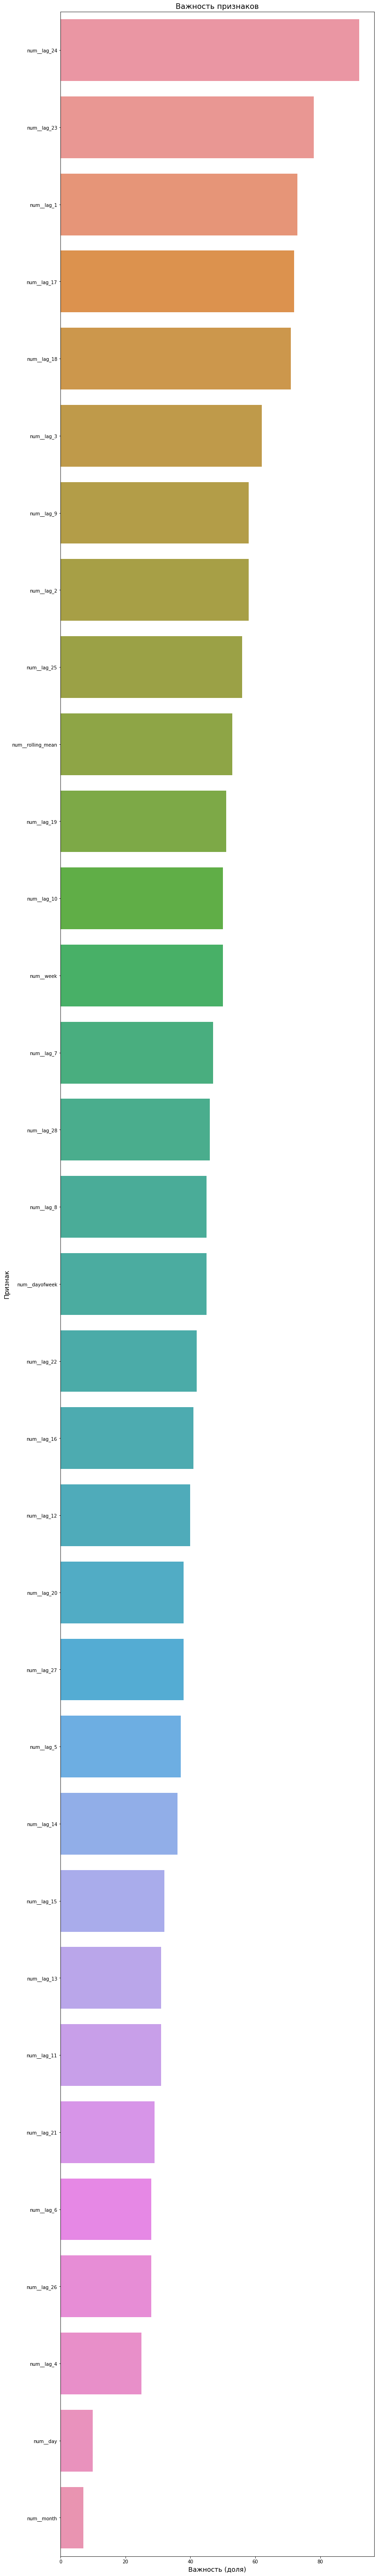

In [28]:
# построение гистограммы с важностью признаков

plt.figure(figsize=(12, 100))

ax = sns.barplot(x='importance', y='feature', data=feature_importances)

ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

# отображаем график
plt.show()

In [29]:
# объединенеие y_test и y_test_pred в  один dataframe
results = y_test.copy()
results = results.reset_index()
results['pred'] = pd.Series(y_test_pred).values
results = results.set_index('datetime', drop=True)
results.head()

,num_orders,pred
datetime,,
2018-08-13 17:00:00,152,123.112719
2018-08-13 18:00:00,104,89.014518
2018-08-13 19:00:00,91,99.656876
2018-08-13 20:00:00,82,99.039689
2018-08-13 21:00:00,160,112.455446


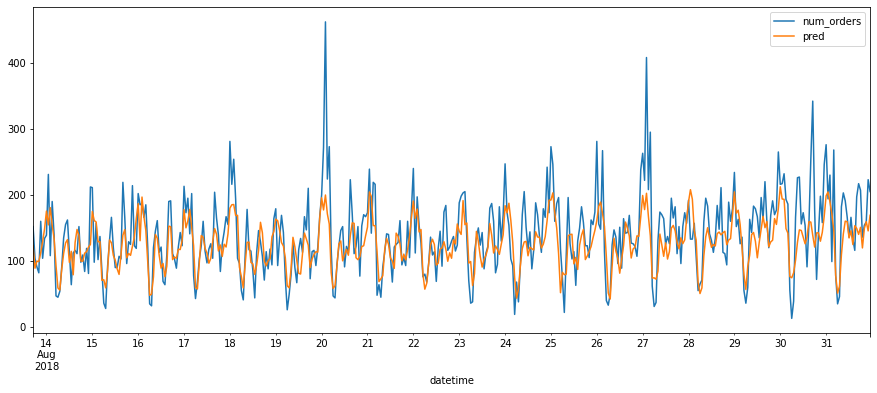

In [30]:
# построение на графике тестовго и предсказанного целевых признаков
results.plot(figsize=(15, 6));

**Вывод**
В результате обучения получена лучша я модель со следующими значениями метрик:
- Метрикака лучшей модели на тренировочной выборке: 24.6
- Метрика на тестовой выборке: 43.0

Лучшая модель: LGBMRegressor()
Параметры: MinMaxScaler(), max_depth=11, n_estimators=50, boosting_type=gbdt
                 
Анализ значимости признаков показал, что большое знчение имели признаки, которые были получены сдвигом num_orders и rolling_mean.

## Выводы

После ресемлпрования полученных данных по одному часу в датасете было 4 416 строк.

В датасет были добавлены дополнительные признаки. Суммарно 34 новых признака. Один из которых (year) в последствии был удален, т.к. содержал в себе только одно значение.

Был создан пайплан и подобраны гиперпараметры. В результате "победила" следующая модель:

LGBMRegressor() с параметрами: MinMaxScaler(), max_depth=11, n_estimators=50, boosting_type=gbdt

Моедль имеет следующие метрики:
- Метрикака лучшей модели на тренировочной выборке: 24.6
- Метрика на тестовой выборке: 43.0

Визуальное сравненеие предсказанных данных с тестовыми показывают сходство.